# Import Modules

In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Connect to Coppelia

In [3]:
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)


0

# Codding to Plot

In [4]:
# Apenas para visualização de um referencial no plano
def plot_frame(Porg, R, c=['r', 'g']):
    
    axis_size = 3.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
        
    # X
    plt.quiver(*Porg[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

In [5]:
def plot3CompostTransformation(middleMatrix, destMatrix):
    aorg = np.array([0, 0])
    

    # Definindo Tbc
    Tbc = destMatrix
    pb_corg = Tbc[0:3, 3]
    Rbc = Tbc[:3,:3]

    # Definindo Tab
    Tab = middleMatrix
    pa_borg = Tab[:3, 3]
    Rab = Tab[:3,:3]
    
    # Definindo Tac
    Tac = Tab @ Tbc
    
    # Plotando os referenciais
    plt.figure()

    # The rotation matrix contain the axis orientation
    # Frame C->B
    pa_corg = np.array(Tac[:,3])
    ## Vector from the origin B to origin C from the perpective of A
    pb_corg_aux = Rab @ pb_corg
    Rac = Tac[:3,:3]
    ## plot the C axis and the vector from the B axis to C axis
    plot_frame(pa_corg, Rac, ['g', 'g'])
    plt.quiver(*pa_borg[:2], *pb_corg_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)

    # Frame B->A
    plot_frame(pa_borg, Rab, ['b', 'b'])
    plt.quiver(*aorg, *pa_borg[:2], color='b', angles='xy', scale_units='xy', scale=1)

    plt.axis('scaled')
    plt.axis((-15, 15, -15, 15))
    

# Codding to calculate the Transformation Matrix

In [6]:
# Function the invert a matrix
def invertMatrix(M):
    return np.linalg.inv(M)

In [7]:
# Get Object Position and Orientation
def getPositionAndOrientation(handle, referenceTo):
    pos = sim.getObjectPosition(handle, referenceTo)
    ori = sim.getObjectOrientation(handle, referenceTo)
    return pos, ori

In [24]:
# Get Rotation Matrix fixed on Z axis
def getRotationMatrixZfixed(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [27]:
# get the transformation from local axis to global axis

def getTransformationMatrix(handle, referenceTo=sim.handle_world):
    pos, ori = getPositionAndOrientation(handle, referenceTo)
    rotM = getRotationMatrixZfixed(ori[2])
    transM = pos 
    scale = np.array([0, 0, 0, 1])

    # Local to Global
    M_L2G = np.column_stack((rotM, transM))
    M_L2G = np.row_stack((M_L2G, scale))

    return M_L2G



In [28]:
# Get the tranfortion from object to another object

def getTransformationMatrixObject2Object(sourceObject, desObject,printPlot = False):
    M_S2G = getTransformationMatrix(sourceObject)
    M_G2S = invertMatrix(M_S2G)
    M_D2G = getTransformationMatrix(desObject)

    if printPlot:
        plot3CompostTransformation(M_G2S, M_D2G)

    return M_G2S @ M_D2G

# Exercise 3

In [89]:
sim.startSimulation()

# Get Objects Handle
personHandle = sim.getObject("/Rapha")
chairHandle = sim.getObject("/Chair")
treeHandle = sim.getObject("/Tree")
diningTableHandle = sim.getObject("/diningTable")
rackHandle = sim.getObject("/Rack")
robotHanle = sim.getObject("/Robot")

# Get transformation Matriz from local to a object reference
result = getTransformationMatrixObject2Object(robotHanle, personHandle, printPlot = True)
# print(result)

sim.stopSimulation()

Exception: 1308: in sim._getObject: object does not exist, or alias/path is ill formatted.

# Exercise 4

[0,5 pts] Coloque o robô em outras três posições diferentes da cena e faça os respectivos plots
(referenciais e relacionamentos), verificando que a implementação funciona para diferentes
casos. Lembre-se de também variar a orientação do robô em relação aos elementos, por
exemplo, colocando ele de frente, de lado e de costas.

## 4.1

## 4.2

## 4.3

# Exercise 5

[1,5 pts] Substitua o robô adicionado inicialmente na cena pelo robô com laser mostrado em
aula. No exemplo que vimos, o plot da leitura do laser está sendo feito no referencial local do
laser. Defina as matrizes de transformações 𝑅𝐿𝑇 (laser → robô) e 𝑊𝑅𝑇 (robô → mundo), e em
seguida modifique o script original para que os pontos agora sejam plotados no referencial
global, de acordo com a posição atual do robô (recuperada pela RemoteAPI). Coloque o robô
em outras diferentes posições da cena (e.g., três) e faça os plots das leituras do laser.

## O que fazer

- Substituir o robo da cena 3 pelo robo usado durante a aula 03 (done) 
- Entender como funciona o script para coletar os dados (done) 
- Se for preciso modificar o script que coleta os dados (done)
- Calcular a matriz de transformação do laser para o mundo
- Integrar os dados coletados ao meu código 
- Fazer os plots
- Criar funções para fazer isso (maybe)

## Import Modules

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

## Define Functions

### Get Data from the sensor

In [12]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id, sim.simx_opmode_streaming)
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id)

    # print(range_data_signal_id)
    resultCodeRanges = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    # returnCodeAngles, string_angle_data = sim.simxGetStringSignal(angle_data_signal_id, sim.simx_opmode_blocking)
    
    resultCodeAngles = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if resultCodeRanges != None and resultCodeAngles != None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(resultCodeRanges)
        raw_angle_data = sim.unpackFloatTable(resultCodeAngles)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None


In [29]:

def draw_laser_data(laser_data, max_sensor_range=5, ax = None):
    
    if (ax == None):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

In [30]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

import numpy as np
import matplotlib.pyplot as plt
import time
import math

client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)


sim.startSimulation()

# Get Objects Handle
# personHandle = sim.getObject("/Rapha")
# chairHandle = sim.getObject("/Chair")
# treeHandle = sim.getObject("/Tree")
# diningTableHandle = sim.getObject("/diningTable")
# rackHandle = sim.getObject("/Rack")
# robotHanle = sim.getObject("/Robot")

sensorData = readSensorData()
if sensorData != None:
    sensorRanges = sensorData[0]
    sensorAngles = sensorData[1]

robotHandle = sim.getObject("/Pioneer_p3dx")
laserHandle = sim.getObject("/Pioneer_p3dx/fastHokuyo")

# Laser Position in relation to the robot
print(sim.getObjectPosition(laserHandle, robotHandle ))
print(sim.getObjectOrientation(laserHandle, robotHandle))

T_rl = getTransformationMatrix(laserHandle, robotHandle)
T_rw = getTransformationMatrix(robotHandle)

T_wl = T_rw @ T_rl

print(T_wl)


sim.stopSimulation()

[0.0, 8.881784197001252e-16, 0.1500000059604646]
[-4.836378138852203e-06, 5.5280768705889455e-05, 2.828016514281492e-16]
[[-0.76604372  0.64278847  0.         -1.19447179]
 [-0.64278847 -0.76604372  0.         -1.87499833]
 [ 0.          0.          1.          0.73879307]
 [ 0.          0.          0.          1.        ]]


Connected to remote API server
[[-1.57079637  4.9994998 ]
 [-1.56785512  4.9994998 ]
 [-1.5648967   4.9994998 ]
 ...
 [ 1.5648967   4.9994998 ]
 [ 1.56785512  4.9994998 ]
 [ 1.57079637  4.9994998 ]]
Pos:  [-1.194471788406364, -1.8749983310699476, 0.4747518112659451]
Program ended


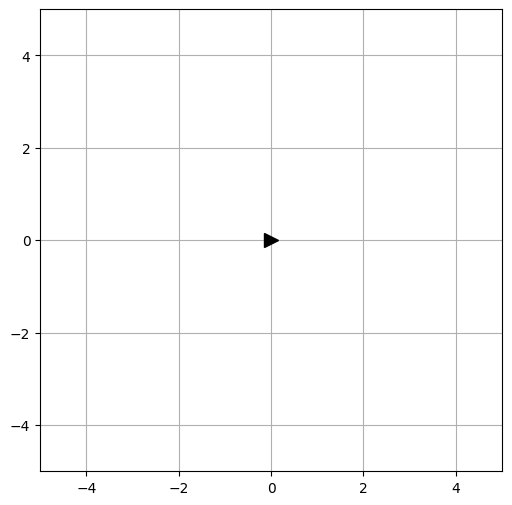

In [31]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

import numpy as np
import matplotlib.pyplot as plt
import time
import math

client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)


sim.startSimulation()

print ('Connected to remote API server')
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)     

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas

range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

print(laser_data)
draw_laser_data(laser_data)

pos = sim.getObjectPosition(robotHandle, sim.handle_world)        
print('Pos: ', pos)

#raise SystemExit()

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

sim.stopSimulation()
    
print ('Program ended')

## Exercise 6

In [38]:

def draw_laser_data_World_Ref(MTrans, laser_data, max_sensor_range=5, ax = None):
    
    if (ax == None):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            p = np.zeros((4, 1))
            
            # Eixo x
            p[0] = dist * np.cos(ang)
            # Eixo y
            p[1] = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'

            # Eixo Z, como é 2D o valor pode ser zero
            # p[2] = 0
            # Perspectiva
            p[3] = 1

            new_point = MTrans @ p

            ax.plot(new_point[0], new_point[1], 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)

        
    ax.grid()
    # ax.set_xlim([-max_sensor_range, max_sensor_range])
    # ax.set_ylim([-max_sensor_range, max_sensor_range])

Connected to remote API server
[[ 0.49957983 -0.86626785  0.         -5.32344901]
 [ 0.86626785  0.49957983  0.          5.69106427]
 [ 0.          0.          1.          0.59003815]
 [ 0.          0.          0.          1.        ]]
Program ended


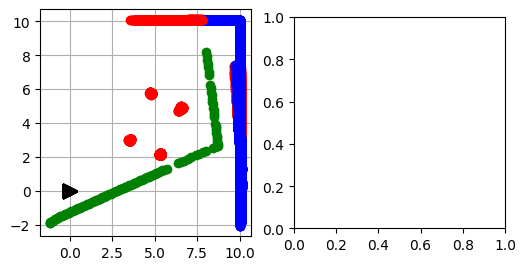

In [41]:
sim.startSimulation()

print ('Connected to remote API server')
    
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)     

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)


# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

print(T_wl)

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas

range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    # sim.step() responsável por sincronizar com a emulação
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

#raise SystemExit()

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

###################################################

#        Maybe this part is the exercise 6

###################################################

fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(121, aspect='equal')
ax1 = fig.add_subplot(122, aspect='equal')

t = 0
# Lembrar de habilitar o 'Real-time mode'
startTime=time.time()
lastTime = startTime
while t < 20:
    
    now = time.time()
    dt = now - lastTime

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    # Matriz de transformação do laser para o mundo
    ## Matrix de transformação laser para o robo
    T_rl = getTransformationMatrix(laserHandle, robotHandle)
    ## Matrix de transformação robo para o mundo
    T_rw = getTransformationMatrix(robotHandle)
    ## Matrix de transformaçao laser para o mundo
    T_wl = T_rw @ T_rl



    pos = sim.getObjectPosition(robotHandle, sim.handle_world)        
    # print('Pos: ', pos)

    ax.plot(pos[0], pos[1], 'o', color='g')

    draw_laser_data_World_Ref(T_wl, laser_data, ax = ax)
    # draw_laser_data(laser_data, ax = ax1)
    
    # Velocidade básica (linear, angular)
    v = 0
    w = np.deg2rad(0)      

    frente = int(len(laser_data)/2)
    lado_direito = int(len(laser_data)*1/4)
    lado_esquerdo = int(len(laser_data)*3/4)
    
    if laser_data[frente, 1] > 2:
        v = .5
        w = 0
    elif laser_data[lado_direito, 1] > 2:
        v = 0
        w = np.deg2rad(-30)
    elif laser_data[lado_esquerdo, 1] > 2:
        v = 0
        w = np.deg2rad(30)
    
    # Isso é o modelo cinemático, estudaremos detalhadamente depois!
    wl = v/r - (w*L)/(2*r)
    wr = v/r + (w*L)/(2*r)
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)        

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)        
    
sim.stopSimulation()

print ('Program ended')